# Lession 2:

> Putting a model in production

In [ ]:
#| default_exp production

## Initial Checks 

In [ ]:
!conda list | findstr "pytorch"

pytorch                   2.0.1           py3.11_cuda11.8_cudnn8_0    pytorch
pytorch-cuda              11.8                 h24eeafa_5    pytorch
pytorch-ignite            0.4.12                   pypi_0    pypi
pytorch-lightning         2.0.5                    pypi_0    pypi
pytorch-mutex             1.0                        cuda    pytorch


In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:41:10_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [ ]:
!pip list | findstr "fastai" 
!pip list | findstr "duckduckgo"
!pip list | findstr "fastbook"

fastai                   2.7.12
duckduckgo-search        3.8.3
fastbook                 0.0.29


In [ ]:
import torch

In [ ]:
torch.cuda.is_available()

True

## Gather Data

In [ ]:
from fastbook import search_images_ddg
from fastdownload import download_url
from fastai.vision.all import *
import os

In [ ]:
#|exports
#|code-fold: true
def download_pic(name):   
    # File path of the image
    image_path = f'{name}.jpg'

    # Check if the image file exists
    if os.path.exists(image_path):
        print("Image file exists.")
    else:
        print("Image file does not exist.")
        download_url(
            search_images_ddg(f'{name}',
            max_images=1)[0], f'{name}.jpg',
            show_progress=False
        )

    return Image.open(f'{name}.jpg').to_thumb(256,256)

Image file exists.


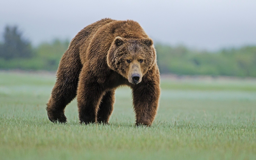

In [ ]:
dest = 'grizzly'
download_pic(dest)

In [ ]:
#|exports
#|code-fold: true
def create_searches_folder(folder_path, searches):
    for i in searches:
        dest = (folder_path/i)
        dest.mkdir(exist_ok=True, parents=True)
        print(f'created {i} folder')

In [ ]:
#|exports
#|code-fold: true
def download_search_images(folder_path, searches, amount):
    for j in searches:
        print(f"downloading images for: {j}")
        download_images(
            folder_path/j,
            urls=search_images_ddg(f'{j} photo', amount),
            n_workers=16
        )

In [ ]:
#|exports
#|code-fold: true
def verify_pics(folder_path):
    failed = verify_images(get_image_files(folder_path))
    failed.map(Path.unlink)
    print(f"Number of images failed: {len(failed)}")

In [ ]:
#|exports
#|code-fold: true
def resize_pics(folder_path, searches):
    for k in searches:
        resize_images(
            folder_path/k,
            max_size=400,
            dest=folder_path/k,
            max_workers=8
        )
        print(f"resizing images for: {k}")

In [ ]:
#|exports
#|code-fold: true
def create_data_folder(folder_path, searches, amount):
    if os.path.exists(folder_path):
        print(f"Folder already exists: {folder_path}")
    else:   
        create_searches_folder(folder_path, searches)
        download_search_images(folder_path, searches, amount)
        verify_pics(folder_path)
        resize_pics(folder_path, searches)


In [ ]:
#|code-fold: true
searches = ('grizzly bears','black bears','teddy bears')
path = Path('bears')

create_data_folder(path, searches, 200)

Folder already exists: bears


## Data Augmentation and Designing model

In [ ]:
?DataBlock

Init signature:
DataBlock(
    blocks: 'list' = None,
    dl_type: 'TfmdDL' = None,
    getters: 'list' = None,
    n_inp: 'int' = None,
    item_tfms: 'list' = None,
    batch_tfms: 'list' = None,
    *,
    get_items=None,
    splitter=None,
    get_y=None,
    get_x=None,
)
Docstring:      Generic container to quickly build `Datasets` and `DataLoaders`.
File:           c:\users\bthek\anaconda3\envs\newai\lib\site-packages\fastai\data\block.py
Type:           type
Subclasses:     

In [ ]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [ ]:
dls = bears.dataloaders(path)

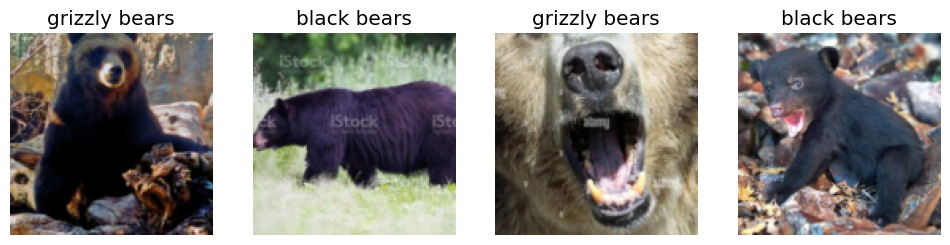

In [ ]:
dls.valid.show_batch(max_n=4, nrows=1)

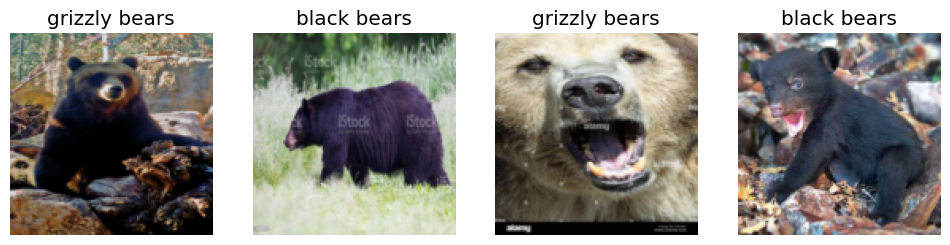

In [ ]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

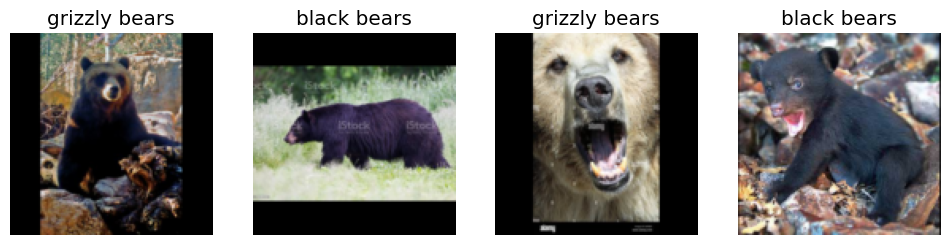

In [ ]:
bears = bears.new(
    item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

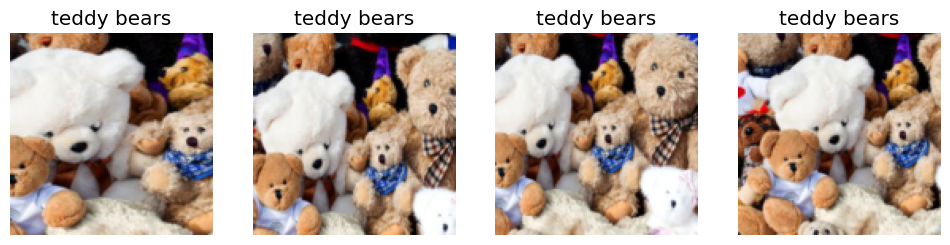

In [ ]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

## Training Your Model, and Using It to Clean Your Data

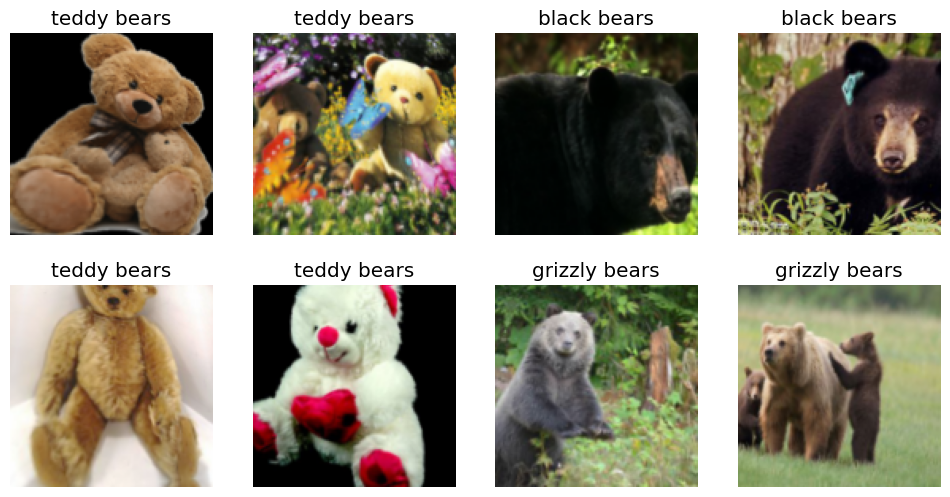

In [ ]:
bears = bears.new(
    item_tfms=RandomResizedCrop(128, min_scale=0.5),
    batch_tfms=aug_transforms(mult=1))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=False)

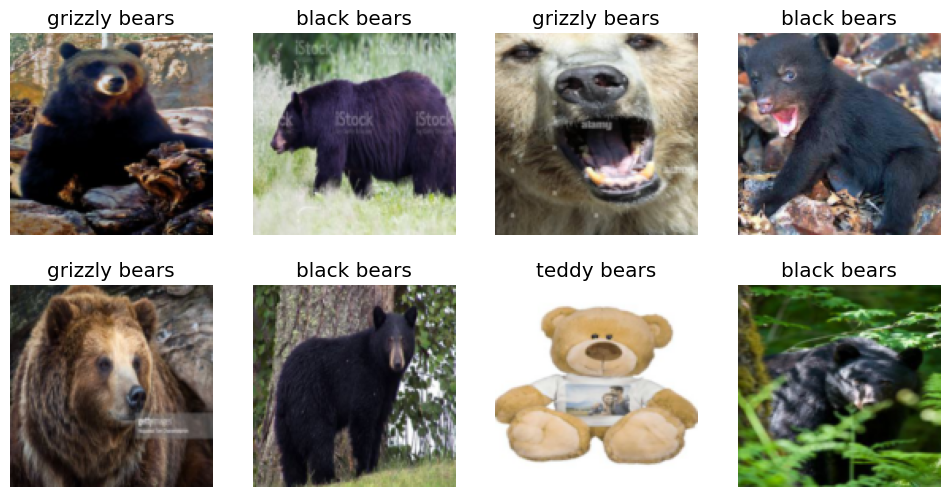

In [ ]:
dls.valid.show_batch(max_n=8, nrows=2, unique=False)

## Training Your Model

In [ ]:
#|eval: false
#|export
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(7)

epoch,train_loss,valid_loss,error_rate,time
0,1.214950,0.308469,0.074766,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.448224,0.322355,0.093458,00:02
1,0.331804,0.262383,0.084112,00:02
2,0.266254,0.324587,0.084112,00:02
3,0.219070,0.390105,0.084112,00:02
4,0.188449,0.420551,0.093458,00:02
5,0.162737,0.446670,0.093458,00:02
6,0.143280,0.433943,0.084112,00:02


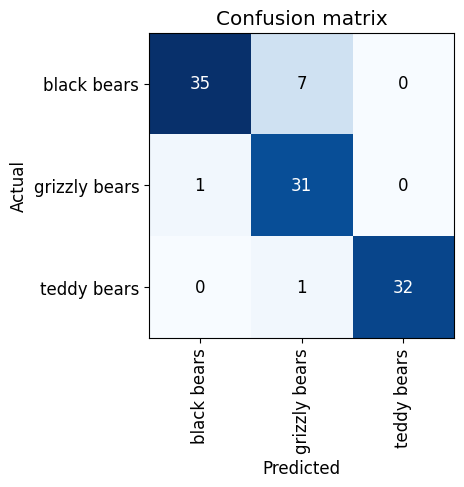

In [ ]:
#|eval: false
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

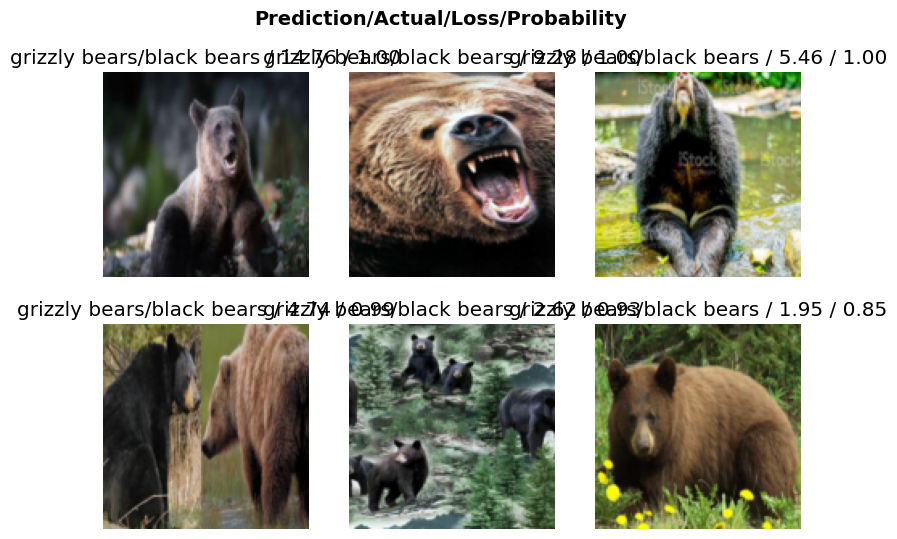

In [ ]:
#|eval: false
interp.plot_top_losses(6, nrows=2)

In [ ]:
#|eval: false
from fastai.vision.widgets import ImageClassifierCleaner

In [ ]:
#|eval: false
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Testing

Probability of grizzly bears is :0.00000.
Probability of black bears is :1.00000.
Probability of teddy bears is :0.00000.
This is a: black bears with probability: 1.00000.


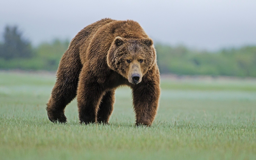

In [ ]:
#|eval: false
searches = ('grizzly bears','black bears','teddy bears')
image= 'grizzly.jpg'


is_real,_,probs = learn.predict(PILImage.create(image))

for index, value in enumerate(searches):
    np.set_printoptions(suppress=True, precision=4)
    print(f"Probability of {value} is :{probs[index]:.5f}.")
    
max_value, max_index = torch.max(probs, dim=0)
print(f"This is a: {searches[max_index]} with probability: {max_value:.5f}.")


Image.open(image).to_thumb(256,256)

## Turning Your Model into an Online Application

In [ ]:
#|eval: false
learn.export('model.pkl')